In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

In [2]:
#With discharge
file_path = r'U:\02_Software\Github\lstm_backward\results\with_discharge\y_obs.csv'
y_obs = pd.read_csv(file_path, parse_dates=[0])
# Set the unnamed first column (dates) as the index
y_obs.set_index(y_obs.columns[0],inplace=True)
file_path = r'U:\02_Software\Github\lstm_backward\results\with_discharge\y_sim.csv'
y_sim = pd.read_csv(file_path, parse_dates=[0])
file_path = r'U:\02_Software\Github\lstm_backward\results\with_discharge\NSE.csv'
nse_disch = pd.read_csv(file_path)
# Set the unnamed first column (dates) as the index
y_sim.set_index(y_sim.columns[0],inplace=True)
file_path = r'U:\02_Software\Github\lstm_backward\results\without_discharge\y_sim.csv'
y_sim_no_disch = pd.read_csv(file_path, parse_dates=[0])
# Set the unnamed first column (dates) as the index
y_sim_no_disch.set_index(y_sim_no_disch.columns[0],inplace=True)
file_path = r'U:\02_Software\Github\lstm_backward\results\without_discharge\NSE.csv'
nse_without_disch = pd.read_csv(file_path)

In [3]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr

# Function to calculate precipitation indices for a single catchment
def calculate_precipitation_indices(series):
    # Initialize a dictionary to store precipitation indices
    indices = {}

    # Total precipitation amount averaged over all days
    indices['avgprcp'] = series.sum(skipna=True) / series.count()

    # Average precipitation amount for rainy days (precipitation > 1 mm)
    rainy_days = series[series > 1]
    indices['avgprcp_rainy'] = rainy_days.mean() if not rainy_days.empty else np.nan

    # Daily precipitation amount corresponding to the 90th percentile
    indices['r90p'] = series.quantile(0.9)

    # Daily precipitation amount corresponding to the 90th percentile of non-zero precipitation
    indices['r90p_1'] = series[series >= 1].quantile(0.90)

    # Daily precipitation amount corresponding to the 95th percentile
    indices['r95p'] = series.quantile(0.95)

    # Daily precipitation amount corresponding to the 95th percentile of non-zero precipitation
    indices['r95p_1'] = series[series >= 1].quantile(0.95)

    # 25th percentile of daily precipitation
    indices['r25p'] = series.quantile(0.25)

    # Maximum 1-day precipitation
    indices['rx1day'] = series.max()

    # Maximum 5-day precipitation
    indices['rx5day'] = series.rolling(window=5, min_periods=1).sum().max()

    # Number of days with precipitation ≥ 10 mm
    indices['r10mm'] = (series >= 10).sum()

    # Number of days with precipitation ≥ 20 mm
    indices['r20mm'] = (series >= 20).sum()

    # Number of wet days (precipitation ≥ 1 mm)
    indices['wetdays'] = (series >= 1).sum()

    # Number of very wet days (≥ 95th percentile of non-zero precipitation days)
    very_wet_threshold = series[series >= 1].quantile(0.95)
    indices['verywetdays'] = (series >= very_wet_threshold).sum()

    # Number of extremely wet days (≥ 99th percentile of non-zero precipitation days)
    extremely_wet_threshold = series[series >= 1].quantile(0.99)
    indices['extremewetdays'] = (series >= extremely_wet_threshold).sum()

    # Calculate RUNAB - Runs above and below the median
    median = series.median()
    series_ab = series.apply(lambda x: 'A' if x > median else 'B')
    runs = (series_ab != series_ab.shift(1)).sum()

    n1 = (series_ab == 'A').sum()
    n2 = (series_ab == 'B').sum()

    if n1 > 20 and n2 > 20:
        mu = (2 * n1 * n2) / (n1 + n2) + 1
        sigma = np.sqrt((2 * n1 * n2 * (2 * n1 * n2 - n1 - n2)) / ((n1 + n2) ** 2 * (n1 + n2 - 1)))
        z = abs(runs - mu) / sigma
        indices['RUNAB'] = z
    else:
        indices['RUNAB'] = np.nan  # Set to NaN if not enough data

    # Calculate Spearman lag-1 autocorrelation for ranks
    ranks = series.rank()
    ranks_lag1 = ranks.shift(1)
    valid_idx = ranks_lag1.notna() & ranks.notna()
    spearman_corr, _ = spearmanr(ranks[valid_idx], ranks_lag1[valid_idx])
    indices['spearman_lag1'] = spearman_corr

    return pd.Series(indices)

In [4]:
# Apply the precipitation indices function to each catchment column for y_obs
results_era5 = y_obs.apply(calculate_precipitation_indices, axis=0).T
results_era5['Catchment'] = results_era5.index

# Apply the precipitation indices function to each catchment column for y_sim
results_y_sim = y_sim.apply(calculate_precipitation_indices, axis=0).T
results_y_sim['Catchment'] = results_y_sim.index

# Apply the precipitation indices function to each catchment column for y_sim_no_disch
results_y_sim_no_disch = y_sim_no_disch.apply(calculate_precipitation_indices, axis=0).T
results_y_sim_no_disch['Catchment'] = results_y_sim_no_disch.index


C:\Users\as2023\AppData\Local\Temp\ipykernel_4812\2784419418.py:11: RuntimeWarning: invalid value encountered in scalar divide
  indices['avgprcp'] = series.sum(skipna=True) / series.count()
C:\Users\as2023\AppData\Local\Temp\ipykernel_4812\2784419418.py:11: RuntimeWarning: invalid value encountered in scalar divide
  indices['avgprcp'] = series.sum(skipna=True) / series.count()
C:\Users\as2023\AppData\Local\Temp\ipykernel_4812\2784419418.py:11: RuntimeWarning: invalid value encountered in scalar divide
  indices['avgprcp'] = series.sum(skipna=True) / series.count()
C:\Users\as2023\AppData\Local\Temp\ipykernel_4812\2784419418.py:11: RuntimeWarning: invalid value encountered in scalar divide
  indices['avgprcp'] = series.sum(skipna=True) / series.count()
C:\Users\as2023\AppData\Local\Temp\ipykernel_4812\2784419418.py:11: RuntimeWarning: invalid value encountered in scalar divide
  indices['avgprcp'] = series.sum(skipna=True) / series.count()
C:\Users\as2023\AppData\Local\Temp\ipykernel_

In [6]:
# Rename columns for clarity before merging
results_era5_renamed = results_era5.rename(columns=lambda x: f"era5_{x}")
results_y_sim_renamed = results_y_sim.rename(columns=lambda x: f"y_sim_{x}")
results_y_sim_no_disch_renamed = results_y_sim_no_disch.rename(columns=lambda x: f"y_sim_no_disch_{x}")

# Merge the DataFrames
combined_results = pd.merge(results_era5_renamed, results_y_sim_renamed, left_index=True, right_index=True)
combined_results = pd.merge(combined_results, results_y_sim_no_disch_renamed, left_index=True, right_index=True)

# Reset index if needed, for easier manipulation
combined_results.reset_index(inplace=True)

# Display the merged DataFrame
print(combined_results.head())

          index  era5_avgprcp  era5_avgprcp_rainy  era5_r90p  era5_r90p_1  \
0  GRDC_6140100      2.383335            5.107542      6.770       11.283   
1  GRDC_6140101      2.279040            5.005228      6.540       10.670   
2  GRDC_6140120      2.285547            5.252399      6.822       11.150   
3  GRDC_6140130      3.103167            6.037563      9.022       12.608   
4  GRDC_6140140      2.998241            5.969102      8.710       12.456   

   era5_r95p  era5_r95p_1  era5_r25p  era5_rx1day  era5_rx5day  ...  \
0     10.571      14.7105       0.07        46.24       101.48  ...   
1      9.980      14.6275       0.06        46.73        97.38  ...   
2     10.170      14.8910       0.04        60.86       104.07  ...   
3     12.545      16.6475       0.08        53.13       112.26  ...   
4     12.312      16.2920       0.06        59.22       107.06  ...   

   y_sim_no_disch_rx1day  y_sim_no_disch_rx5day  y_sim_no_disch_r10mm  \
0              37.345585             

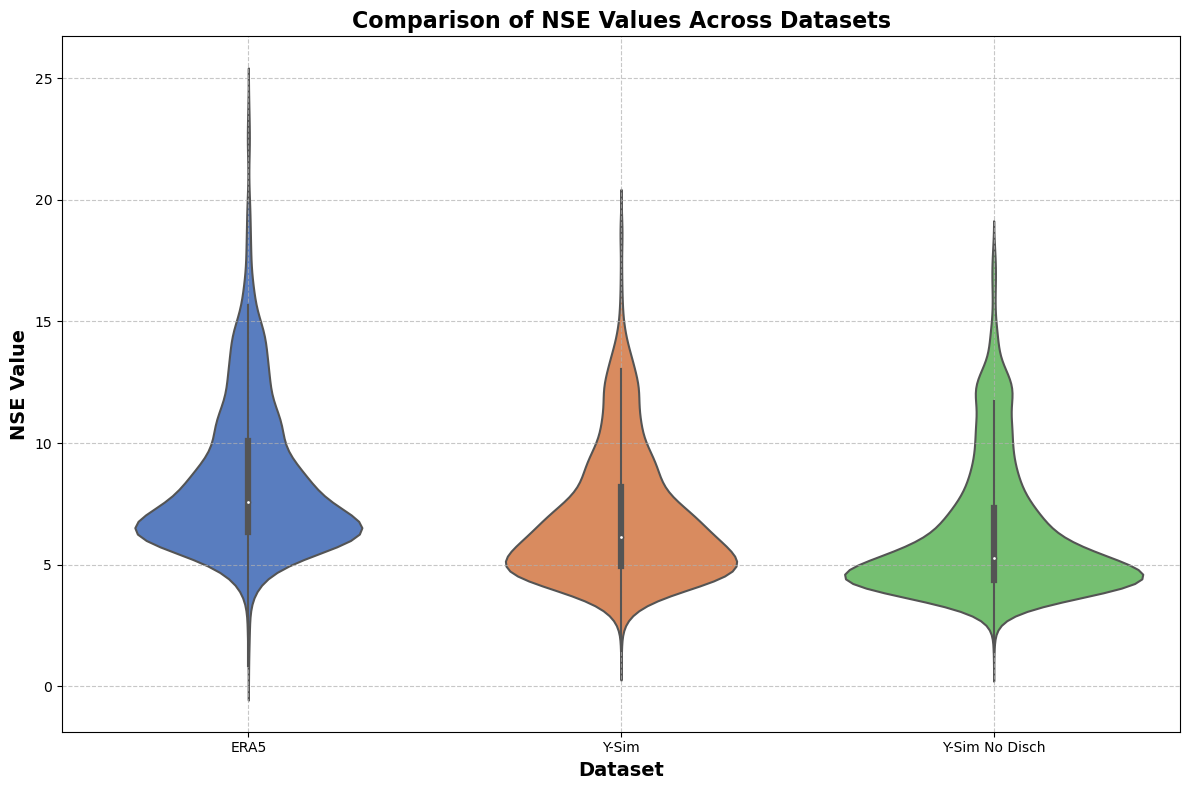

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_violin_comparison(df, col_era5, col_y_sim, col_y_sim_no_disch, title='Comparison of NSE Values'):
    # Extract relevant columns and reshape for plotting
    df_melted = df.melt(
        id_vars=['era5_Catchment'],
        value_vars=[col_era5, col_y_sim, col_y_sim_no_disch],
        var_name='Source',
        value_name='Value'
    )
    
    # Map the source names to more readable names
    df_melted['Source'] = df_melted['Source'].map({
        col_era5: 'ERA5',
        col_y_sim: 'Y-Sim',
        col_y_sim_no_disch: 'Y-Sim No Disch'
    })
    
    # Create a violin plot
    plt.figure(figsize=(12, 8))
    sns.violinplot(x='Source', y='Value', data=df_melted, palette='muted')

    # Customize the plot
    plt.title(title, fontsize=16, weight='bold')
    plt.xlabel('Dataset', fontsize=14, weight='bold')
    plt.ylabel('NSE Value', fontsize=14, weight='bold')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Show the plot
    plt.tight_layout()
    plt.show()

# Example usage
plot_violin_comparison(
    df=combined_results,
    col_era5='era5_r90p',  # Column for ERA5 data
    col_y_sim='y_sim_r90p',  # Column for Y-Sim data
    col_y_sim_no_disch='y_sim_no_disch_r90p',  # Column for Y-Sim No Discharge data
    title='Comparison of NSE Values Across Datasets'
)

In [10]:
# Load the second CSV file containing basin_id, lat, and lon
df2 = pd.read_csv(r"C:\Users\as2023\bwSyncShare\01_Analysis\03_Backward_Hydrology\01_Analysis\01_baseline\grdc_caravan.csv", usecols=['gauge_id', 'gauge_lat', 'gauge_lon'])
df3 = pd.read_csv(r"S:\ashish\01_Analysis\01_Europe_Flood_Analysis\Caravan\Caravan\attributes\camelsgb\attributes_other_camelsgb.csv",usecols=['gauge_id', 'gauge_lat', 'gauge_lon'])
# Rename 'gauge_id' 
df2.rename(columns={'gauge_id': 'Catchment'}, inplace=True)
df3.rename(columns={'gauge_id': 'Catchment'}, inplace=True)
latlon_df = pd.concat([df2, df3], axis=0, ignore_index=True) 

In [13]:
# Merge the two dataframes based on the 'basin_id' column
combined_results.rename(columns={'era5_Catchment': 'Catchment'}, inplace=True)
merged_df = pd.merge(combined_results, latlon_df , on='Catchment', how='inner')
merged_df

,index,era5_avgprcp,era5_avgprcp_rainy,era5_r90p,era5_r90p_1,era5_r95p,era5_r95p_1,era5_r25p,era5_rx1day,era5_rx5day,...,y_sim_no_disch_r10mm,y_sim_no_disch_r20mm,y_sim_no_disch_wetdays,y_sim_no_disch_verywetdays,y_sim_no_disch_extremewetdays,y_sim_no_disch_RUNAB,y_sim_no_disch_spearman_lag1,y_sim_no_disch_Catchment,gauge_lat,gauge_lon
0,GRDC_6140100,2.383335,5.107542,6.770,11.283,10.571,14.7105,0.070,46.24,101.48,...,88.0,16.0,3644.0,183.0,37.0,19.820704,0.403723,GRDC_6140100,50.531200,16.189600
1,GRDC_6140101,2.279040,5.005228,6.540,10.670,9.980,14.6275,0.060,46.73,97.38,...,84.0,15.0,3611.0,181.0,37.0,20.253057,0.403544,GRDC_6140101,50.481300,16.181200
2,GRDC_6140120,2.285547,5.252399,6.822,11.150,10.170,14.8910,0.040,60.86,104.07,...,82.0,13.0,3542.0,178.0,36.0,21.604162,0.419291,GRDC_6140120,49.889600,15.481200
3,GRDC_6140130,3.103167,6.037563,9.022,12.608,12.545,16.6475,0.080,53.13,112.26,...,153.0,17.0,4084.0,205.0,41.0,20.955632,0.419374,GRDC_6140130,50.639600,15.518800
4,GRDC_6140140,2.998241,5.969102,8.710,12.456,12.312,16.2920,0.060,59.22,107.06,...,141.0,16.0,3974.0,199.0,40.0,22.360780,0.422535,GRDC_6140140,50.656200,15.327100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1799,camelsgb_95001,4.257740,6.048317,10.612,12.370,13.832,15.7700,0.605,44.85,92.40,...,190.0,7.0,4886.0,245.0,49.0,27.657111,0.519788,camelsgb_95001,58.174122,-5.152603
1800,camelsgb_96001,3.211281,4.888298,8.106,9.786,10.521,12.6240,0.440,51.77,99.46,...,70.0,1.0,4848.0,243.0,49.0,22.171626,0.420851,camelsgb_96001,58.478811,-3.903019
1801,camelsgb_96002,3.436948,5.118097,8.600,10.280,11.531,13.3880,0.450,50.82,96.91,...,74.0,2.0,4843.0,243.0,49.0,24.063172,0.452396,camelsgb_96002,58.480072,-4.207749
1802,camelsgb_96004,3.827994,5.578480,9.530,11.311,12.420,14.4800,0.540,51.14,97.49,...,123.0,5.0,4880.0,244.0,49.0,25.684498,0.485407,camelsgb_96004,58.347177,-4.644621


In [52]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def plot_world_map(df, index_column, extent,  cmap_color, vmin=None, vmax=None):
    df_cleaned = df.dropna(subset=['gauge_lat', 'gauge_lon', index_column])
    fig = plt.figure(figsize=(9, 6))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

    ax.set_extent(extent)

    ax.add_feature(cfeature.LAND, color="lightgrey")
    ax.add_feature(cfeature.OCEAN, color='#deebf7')
    ax.add_feature(cfeature.COASTLINE)
    
    # Get the minimum and maximum values of the index column for custom colormap limits
    if vmin is None:
        vmin = df_cleaned[index_column].min()
    if vmax is None:
        vmax = df_cleaned[index_column].max()

    # Plot the latitude and longitude points with the specified index values
    sc = ax.scatter(df_cleaned['gauge_lon'], df_cleaned['gauge_lat'], c=df_cleaned[index_column], cmap=cmap_color, 
                    marker='o', transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, s=10, edgecolors='white', linewidths=0.2)

    # Add colorbar
    cbar = plt.colorbar(sc, ax=ax,  shrink=0.6, extend='both')
    cbar.set_label(index_column)

    ax.coastlines()

    plt.show()

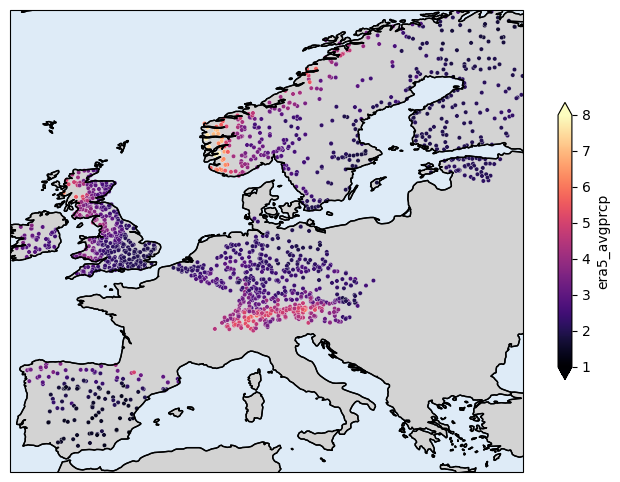

In [53]:
# Manually set the latitude and longitude extent
europe_extent = [-10, 30, 35, 70]
# Specify the index column to plot
index_column = 'era5_avgprcp'  # Replace 'NSE' with the name of your index column

# Plot the world map
plot_world_map(merged_df, index_column, europe_extent, vmin =1, vmax=8, cmap_color='magma')

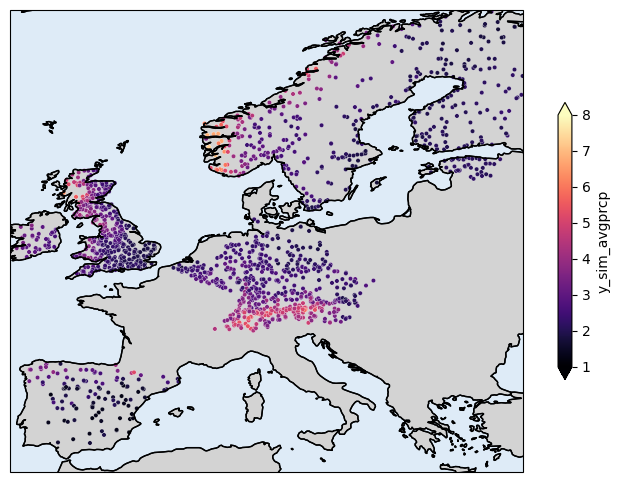

In [58]:
# Manually set the latitude and longitude extent
europe_extent = [-10, 30, 35, 70]
# Specify the index column to plot
index_column = 'y_sim_avgprcp'  # Replace 'NSE' with the name of your index column

# Plot the world map
plot_world_map(merged_df, index_column, europe_extent, vmin =1, vmax=8, cmap_color='magma')

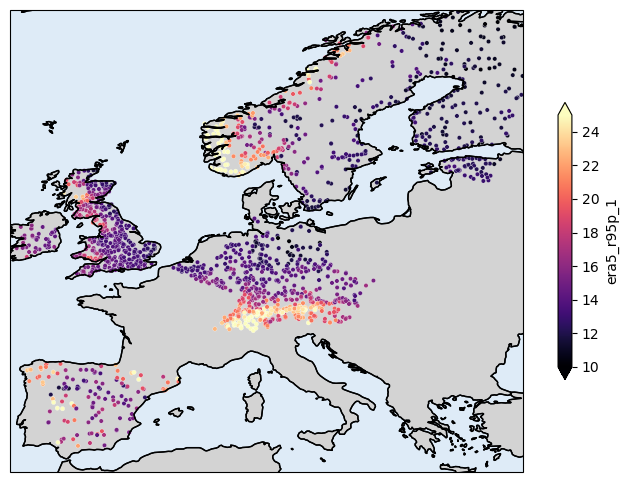

In [59]:
# Manually set the latitude and longitude extent
europe_extent = [-10, 30, 35, 70]
# Specify the index column to plot
index_column = 'era5_r95p_1'  # Replace 'NSE' with the name of your index column

# Plot the world map
plot_world_map(merged_df, index_column, europe_extent, vmin =10, vmax=25, cmap_color='magma')

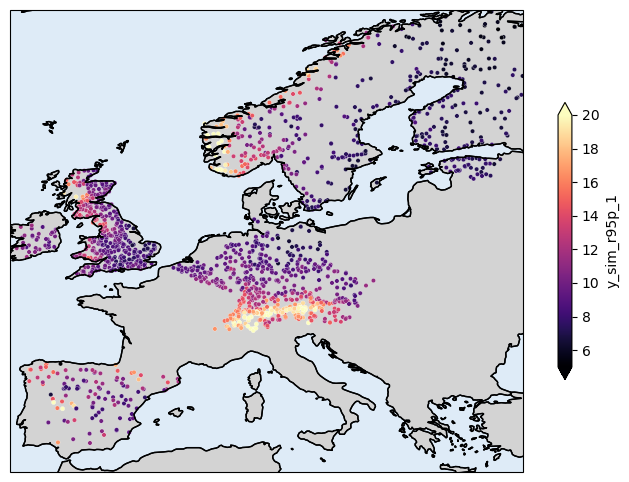

In [57]:
# Manually set the latitude and longitude extent
europe_extent = [-10, 30, 35, 70]
# Specify the index column to plot
index_column = 'y_sim_r95p_1'  # Replace 'NSE' with the name of your index column

# Plot the world map
plot_world_map(merged_df, index_column, europe_extent, vmin =5, vmax=20, cmap_color='magma')

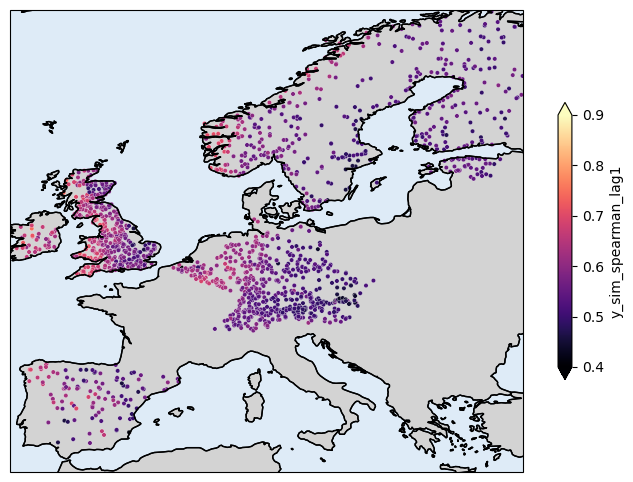

In [61]:
# Manually set the latitude and longitude extent
europe_extent = [-10, 30, 35, 70]
# Specify the index column to plot
index_column = 'y_sim_spearman_lag1'  # Replace 'NSE' with the name of your index column

# Plot the world map
plot_world_map(merged_df, index_column, europe_extent, vmin =0.4, vmax=0.9, cmap_color='magma')

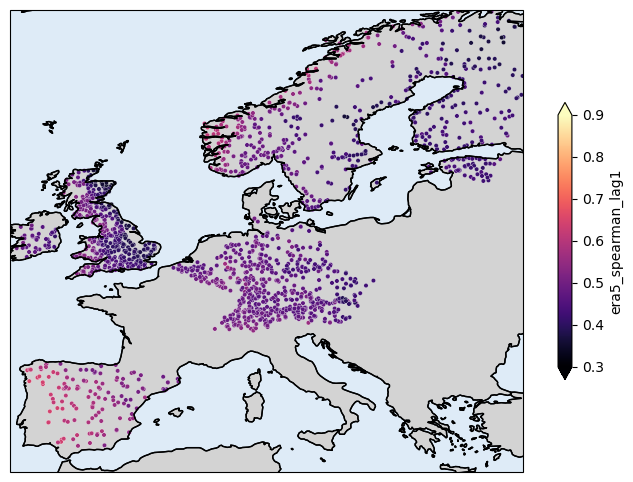

In [66]:
# Manually set the latitude and longitude extent
europe_extent = [-10, 30, 35, 70]
# Specify the index column to plot
index_column = 'era5_spearman_lag1'  # Replace 'NSE' with the name of your index column

# Plot the world map
plot_world_map(merged_df, index_column, europe_extent, vmin =0.3, vmax=0.9, cmap_color='magma')

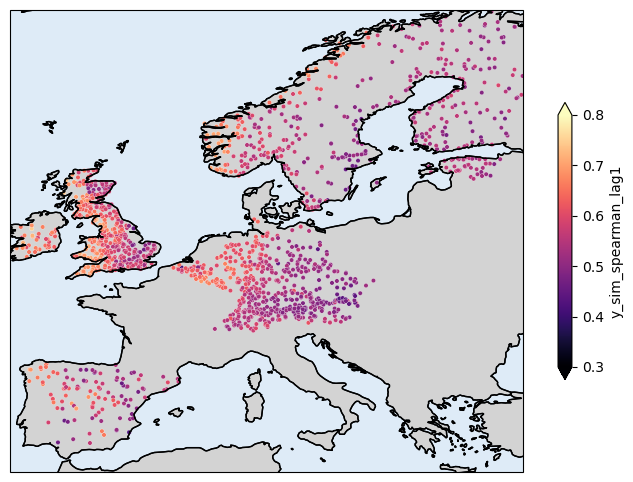

In [71]:
# Manually set the latitude and longitude extent
europe_extent = [-10, 30, 35, 70]
# Specify the index column to plot
index_column = 'y_sim_spearman_lag1'  # Replace 'NSE' with the name of your index column

# Plot the world map
plot_world_map(merged_df, index_column, europe_extent, vmin =0.3, vmax=0.8, cmap_color='magma')

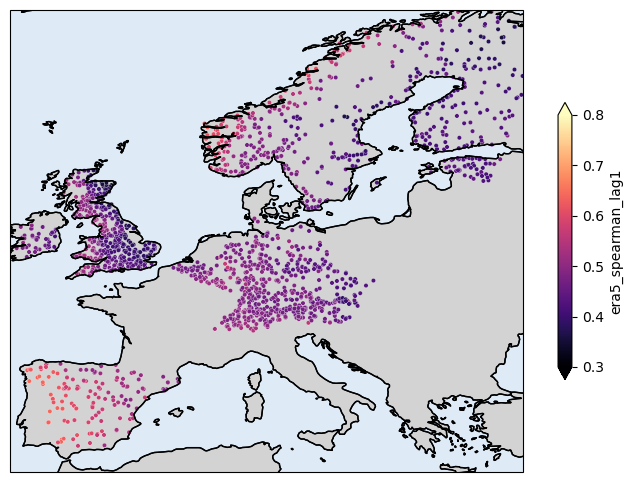

In [72]:
# Manually set the latitude and longitude extent
europe_extent = [-10, 30, 35, 70]
# Specify the index column to plot
index_column = 'era5_spearman_lag1'   # Replace 'NSE' with the name of your index column

# Plot the world map
plot_world_map(merged_df, index_column, europe_extent, vmin =0.3, vmax=0.8, cmap_color='magma')